In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from eofs.xarray import Eof
from xarrayutils.utils import linear_trend
import gc
import collections
import statsmodels.api as sm
import scipy

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'

# Data Preparation

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

In [5]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

In [6]:
# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [7]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [8]:
# Remove initial 'model spinup period' data before analysis

spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
flux_clean = flux_anm[spinup_time_period:]

## Remove Amery (test case)

In [ ]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
amery_basin = 34
amery_flux = flux_clean.rio.clip(icems.loc[[amery_basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
amflux = amery_flux.fillna(0)

In [ ]:
flux_clean_amremoved = flux_clean - amflux

## EOF/PCA Decomposition

In [9]:
%%time
##############################
#### EOF/PCA DECOMPOSITION ### 
##############################

fluxsolver = Eof(flux_clean) # using eof.xarray interface

# Define EOFs and PCs
fluxeofs = fluxsolver.eofs()
fluxpcs = fluxsolver.pcs()

CPU times: user 2min 50s, sys: 1min 6s, total: 3min 57s
Wall time: 1min 3s


## Fourier Phase Randomization

In [14]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 2
t_length = fluxpcs.shape[0]

# fluxpcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,fluxpcs.shape[0],fluxpcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(fluxsolver.neofs):
        fl = fluxpcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}'.format(i))
        # plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15) # PLOT LATER! Plotting here adds significant computation time

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated ifft for realization 1
calculated iff

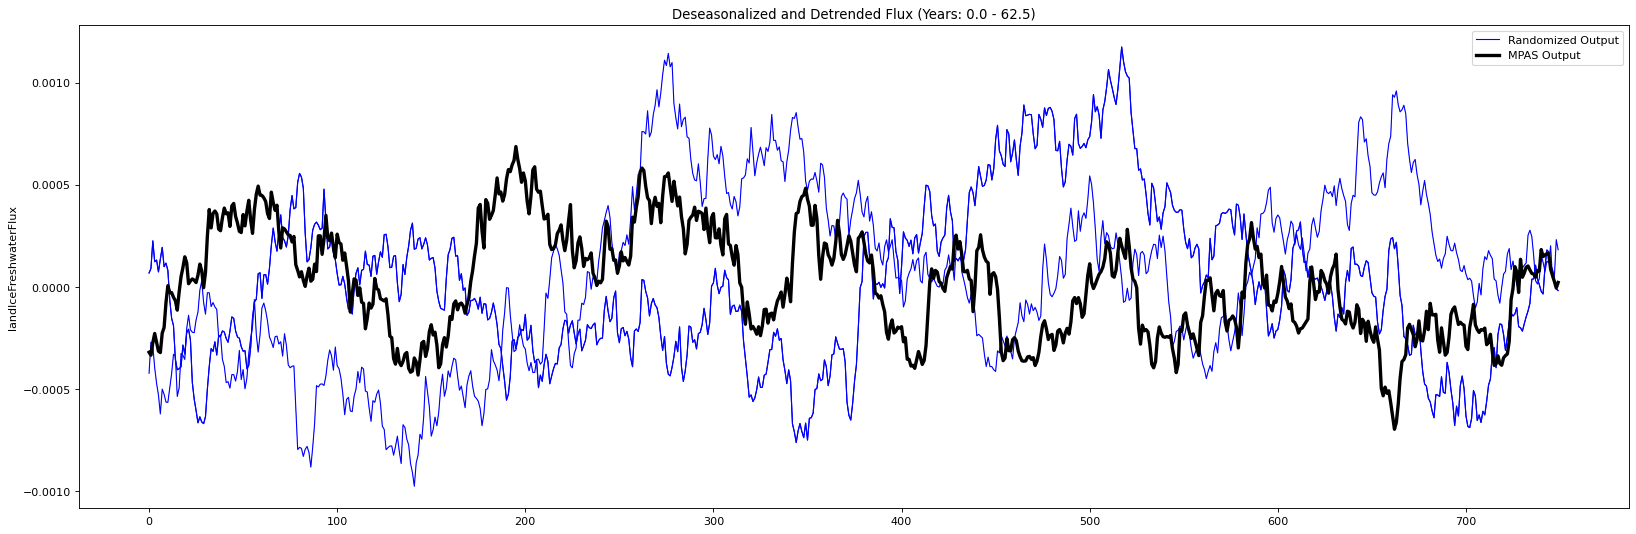

In [15]:
# ======================================================
# PHASE RANDOMIZED TIME SERIES PLOTS (PCs) =============
# ======================================================

plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,1],'b', linewidth=0.15)

plt.plot(new_fl[0,t1:tf,1],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[1,t1:tf,1],'b', linewidth=1)
plt.plot(new_fl[0,t1:tf,1],'b', linewidth=1)
plt.plot(fluxpcs[t1:tf,1],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.
          format((t1)/12,(tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

## Randomized Data Reconstruction

In [16]:
# Helper function for reconstruction
def _valid_nan(in_array):
    inan = np.isnan(in_array)
    return (inan.any(axis=0) == inan.all(axis=0)).all()

In [17]:
%%time
### Reconstruct field: code optimized
# Store the input data in an instance variable.
if flux_clean.ndim < 2:
    raise ValueError('the input data set must be at least two dimensional')
_data = flux_clean.to_numpy().copy()
# Check if the input is a masked array. If so fill it with NaN.
try:
    _data = _data.filled(fill_value=np.nan)
    _filled = True
except AttributeError:
    _filled = False
# Store information about the shape/size of the input data.
_records = _data.shape[0]
_originalshape = _data.shape[1:]
channels = np.product(_originalshape)
# Remove the time mean of the input data unless explicitly told
# not to by the "center" argument.
# Reshape to two dimensions (time, space) creating the design matrix.
_data = _data.reshape([_records, channels])
# Find the indices of values that are not missing in one row. All the
# rows will have missing values in the same places provided the
# array was centered. If it wasn't then it is possible that some
# missing values will be missed and the singular value decomposition
# will produce not a number for everything.
if not _valid_nan(_data):
    raise ValueError('missing values detected in different '
                     'locations at different times')
nonMissingIndex = np.where(np.logical_not(np.isnan(_data[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = _data[:, nonMissingIndex]
if dataNoMissing.size == 0:
    raise ValueError('all input data is missing')
# Compute the singular value decomposition of the design matrix.
try:
    A, Lh, E = np.linalg.svd(dataNoMissing, full_matrices=False)
except (np.linalg.LinAlgError, ValueError):
    raise ValueError('error encountered in SVD, check that missing '
                     'values are in the same places at each time and '
                     'that all the values are not missing')
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
_ddof = 1 # defaults to 1
normfactor = float(_records - _ddof)
_L = Lh * Lh / normfactor
# Store the number of eigenvalues (and hence EOFs) that were actually
# computed.
neofs = len(_L)
# Re-introduce missing values into the eigenvectors in the same places
# as they exist in the input maps. Create an array of not-a-numbers
# and then introduce data values where required. We have to use the
# astype method to ensure the eigenvectors are the same type as the
# input dataset since multiplication by np.NaN will promote to 64-bit.
_flatE = np.ones([neofs, channels],
                      dtype=_data.dtype) * np.NaN
_flatE = _flatE.astype(_data.dtype)
_flatE[:, nonMissingIndex] = E
# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
#_P = A * Lh

CPU times: user 2min 39s, sys: 1min, total: 3min 39s
Wall time: 55.1 s


In [64]:
%%time

####################
# EOF RECONSTRUCTION : REMOVE 1ST EOF (AMERY)
####################

for i in range(1):
    fluxpcs_new = xr.DataArray(new_fl[i], 
                               coords=fluxpcs.coords, 
                               dims = fluxpcs.dims, 
                               attrs=fluxpcs.attrs)
    _P = fluxpcs_new.to_numpy()
    if isinstance(neofs, collections.abc.Iterable):
        modes = [m - 1 for m in 10]
    else:
        modes = slice(0, 10)
    # Project principal components onto the EOFs to compute the
    # reconstructed field.
    print('Calculating data for realization #{}'.format(i))
    rval = np.dot(_P[:, modes], _flatE[modes])
    # Reshape the reconstructed field so it has the same shape as the
    # input data set.
    rval = rval.reshape((_records,) + _originalshape)

    # Return the reconstructed field.
    if _filled:
        rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False))
    
    reconstr_full = xr.DataArray(rval, 
                                 dims = flux_clean.dims, 
                                 coords = flux_clean.coords, 
                                 attrs = flux_clean.attrs)
    reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')
    print('Reconstructed data for realization #{}'.format(i))    
    # Save reconstructed realization
    reconstr_full.to_netcdf(inDirName+
                            interim_data_folder+
                            randomized_realizations_path+
                            'Resid_randomized_flux_EOFrm_n_{}'.
                            format(i))
    print('Saved datafile for realization #{}'.format(i))
    del fluxpcs_new, _P, modes, rval, reconstr_full 
    print('deleting interim variables')
    gc.collect()

Calculating data for realization #0
Reconstructed data for realization #0
Saved datafile for realization #0
deleting interim variables
CPU times: user 2.89 s, sys: 9.09 s, total: 12 s
Wall time: 7.18 s


In [ ]:
%%time

####################
# EOF RECONSTRUCTION 
####################

for i in range(n_realizations):
    fluxpcs_new = xr.DataArray(new_fl[i], 
                               coords=fluxpcs.coords, 
                               dims = fluxpcs.dims, 
                               attrs=fluxpcs.attrs)
    _P = fluxpcs_new.to_numpy()
    if isinstance(neofs, collections.abc.Iterable):
        modes = [m - 1 for m in neofs]
    else:
        modes = slice(0, neofs)
    # Project principal components onto the EOFs to compute the
    # reconstructed field.
    print('Calculating data for realization #{}'.format(i))
    rval = np.dot(_P[:, modes], _flatE[modes])
    # Reshape the reconstructed field so it has the same shape as the
    # input data set.
    rval = rval.reshape((_records,) + _originalshape)

    # Return the reconstructed field.
    if _filled:
        rval = ma.array(rval, mask=np.where(np.isnan(rval), True, False))
    
    reconstr_full = xr.DataArray(rval, 
                                 dims = flux_clean.dims, 
                                 coords = flux_clean.coords, 
                                 attrs = flux_clean.attrs)
    reconstr_full = reconstr_full.rename('timeMonthly_avg_landIceFreshwaterFlux')
    print('Reconstructed data for realization #{}'.format(i))    
    # Save reconstructed realization
    reconstr_full.to_netcdf(inDirName+
                            interim_data_folder+
                            randomized_realizations_path+
                            'Resid_randomized_flux_AMREMOVED_n_{}'.
                            format(i))
    print('Saved datafile for realization #{}'.format(i))
    del fluxpcs_new, _P, modes, rval, reconstr_full 
    print('deleting interim variables')
    gc.collect()

## Open Datasets

In [ ]:
# Select randomized data realization to compare

flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(0))
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [65]:
#flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
#flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_EOFrm_n_{}'.
                                format(0))
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
reconstr_full1 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(1))
flux_reconstr1 = reconstr_full1.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full2 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(2))
flux_reconstr2 = reconstr_full2.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full3 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(3))
flux_reconstr3 = reconstr_full3.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full4 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(4))
flux_reconstr4 = reconstr_full4.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full5 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(5))
flux_reconstr5 = reconstr_full5.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full6 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(6))
flux_reconstr6 = reconstr_full6.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full7 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(7))
flux_reconstr7 = reconstr_full7.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full8 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(8))
flux_reconstr8 = reconstr_full8.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full9 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(9))
flux_reconstr9 = reconstr_full9.timeMonthly_avg_landIceFreshwaterFlux

reconstr_full10 = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(10))
flux_reconstr10 = reconstr_full10.timeMonthly_avg_landIceFreshwaterFlux

# Catchment-based Data Analysis

In [ ]:
flux_reconstr = xr.DataArray(0, dims=flux_clean.dims,
                            coords = flux_clean.coords,
                            attrs = flux_clean.attrs,
                            name = flux_clean.name)

flux_reconstr = flux_reconstr.expand_dims({'realization':n_realizations})
flux_reconstr = flux_reconstr.assign_coords({'realization': flux_reconstr.realization})

In [ ]:
flux_reconstr = np.empty((4,flux_clean.shape[0], flux_clean.shape[1], flux_clean.shape[2]))

for i in range(4):
    reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(i))
    flux_reconstr[i] = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux    
    print('reconstruction added..{}'.format(i))
    del reconstr_full
    print('reconstruction dataset deleted..{}'.format(i))
    gc.collect()

In [ ]:
flux_reconstr = xr.DataArray(flux_reconstr,
                            dims = ['realization','time','y','x'],
                            attrs = flux_clean.attrs,
                            name = flux_clean.name)

In [ ]:
flux_reconstr = xr.DataArray(flux_reconstr,
                            dims = flux_clean.dims,
                            coords = flux_clean.coords,
                            attrs = flux_clean.attrs,
                            name = flux_clean.name)

In [57]:
# LIST OF ALL CATCHMENT BASINS
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

0           Filchner-Ronne
1                     Ross
2               Antarctica
3                Peninsula
4          West Antarctica
5          East Antarctica
6                   IMBIE1
7                   IMBIE2
8                   IMBIE3
9                   IMBIE4
10                  IMBIE5
11                  IMBIE6
12                  IMBIE7
13                  IMBIE8
14                  IMBIE9
15                 IMBIE10
16                 IMBIE11
17                 IMBIE12
18                 IMBIE13
19                 IMBIE14
20                 IMBIE15
21                 IMBIE16
22                 IMBIE17
23                 IMBIE18
24                 IMBIE19
25                 IMBIE20
26                 IMBIE21
27                 IMBIE22
28                 IMBIE23
29                 IMBIE24
30                 IMBIE25
31                 IMBIE26
32                 IMBIE27
33                   Abbot
34                   Amery
35                    Atka
36                 Aviator
3

In [ ]:
# Choose basin/catchment for plotting
basin = 34

# Mask data to chosen basin: 
# original input data and reconstructed data (from selected realization)

flux_reconstr1.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr2.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr3.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr4.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr5.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr6.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr7.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr8.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr9.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr10.rio.write_crs("epsg:3031",inplace=True);

rec_basin1 = flux_reconstr1.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin2 = flux_reconstr2.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin3 = flux_reconstr3.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin4 = flux_reconstr4.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin5 = flux_reconstr5.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin6 = flux_reconstr6.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin7 = flux_reconstr7.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin8 = flux_reconstr8.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin9 = flux_reconstr9.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin10 = flux_reconstr10.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

# Remove NaN mask values to 'zoom' into catchment region
rec_basin1 = rec_basin1.dropna('time',how='all')
rec_basin1 = rec_basin1.dropna('y',how='all')
rec_basin1 = rec_basin1.dropna('x',how='all')
rec_basin1 = rec_basin1.drop("month")


rec_basin2 = rec_basin2.dropna('time',how='all')
rec_basin2 = rec_basin2.dropna('y',how='all')
rec_basin2 = rec_basin2.dropna('x',how='all')
rec_basin2 = rec_basin2.drop("month")

rec_basin3 = rec_basin3.dropna('time',how='all')
rec_basin3 = rec_basin3.dropna('y',how='all')
rec_basin3 = rec_basin3.dropna('x',how='all')
rec_basin3 = rec_basin3.drop("month")

rec_basin4 = rec_basin4.dropna('time',how='all')
rec_basin4 = rec_basin4.dropna('y',how='all')
rec_basin4 = rec_basin4.dropna('x',how='all')
rec_basin4 = rec_basin4.drop("month")

rec_basin5 = rec_basin5.dropna('time',how='all')
rec_basin5 = rec_basin5.dropna('y',how='all')
rec_basin5 = rec_basin5.dropna('x',how='all')
rec_basin5 = rec_basin5.drop("month")

rec_basin6 = rec_basin6.dropna('time',how='all')
rec_basin6 = rec_basin6.dropna('y',how='all')
rec_basin6 = rec_basin6.dropna('x',how='all')
rec_basin6 = rec_basin6.drop("month")

rec_basin7 = rec_basin7.dropna('time',how='all')
rec_basin7 = rec_basin7.dropna('y',how='all')
rec_basin7 = rec_basin7.dropna('x',how='all')
rec_basin7 = rec_basin7.drop("month")

rec_basin8 = rec_basin8.dropna('time',how='all')
rec_basin8 = rec_basin8.dropna('y',how='all')
rec_basin8 = rec_basin8.dropna('x',how='all')
rec_basin8 = rec_basin8.drop("month")

rec_basin10 = rec_basin10.dropna('time',how='all')
rec_basin10 = rec_basin10.dropna('y',how='all')
rec_basin10 = rec_basin10.dropna('x',how='all')
rec_basin10 = rec_basin10.drop("month")

rec_basin9 = rec_basin9.dropna('time',how='all')
rec_basin9 = rec_basin9.dropna('y',how='all')
rec_basin9 = rec_basin9.dropna('x',how='all')
rec_basin9 = rec_basin9.drop("month")

In [53]:
basin = 34
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);
orig_basin = flux_clean.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

rec_basin = flux_reconstr.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

# Remove NaN mask values to 'zoom' into catchment region
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")

In [54]:
# Time series of selected catchment for comparison between original and reconstruction
orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

"""
rec_basin1_ts = rec_basin1.sum(['y','x'])
rec_basin2_ts = rec_basin2.sum(['y','x'])
rec_basin3_ts = rec_basin3.sum(['y','x'])
rec_basin4_ts = rec_basin4.sum(['y','x'])
rec_basin5_ts = rec_basin5.sum(['y','x'])
rec_basin6_ts = rec_basin6.sum(['y','x'])
rec_basin7_ts = rec_basin7.sum(['y','x'])
rec_basin8_ts = rec_basin8.sum(['y','x'])
rec_basin9_ts = rec_basin9.sum(['y','x'])
rec_basin10_ts = rec_basin10.sum(['y','x'])
"""

"\nrec_basin1_ts = rec_basin1.sum(['y','x'])\nrec_basin2_ts = rec_basin2.sum(['y','x'])\nrec_basin3_ts = rec_basin3.sum(['y','x'])\nrec_basin4_ts = rec_basin4.sum(['y','x'])\nrec_basin5_ts = rec_basin5.sum(['y','x'])\nrec_basin6_ts = rec_basin6.sum(['y','x'])\nrec_basin7_ts = rec_basin7.sum(['y','x'])\nrec_basin8_ts = rec_basin8.sum(['y','x'])\nrec_basin9_ts = rec_basin9.sum(['y','x'])\nrec_basin10_ts = rec_basin10.sum(['y','x'])\n"

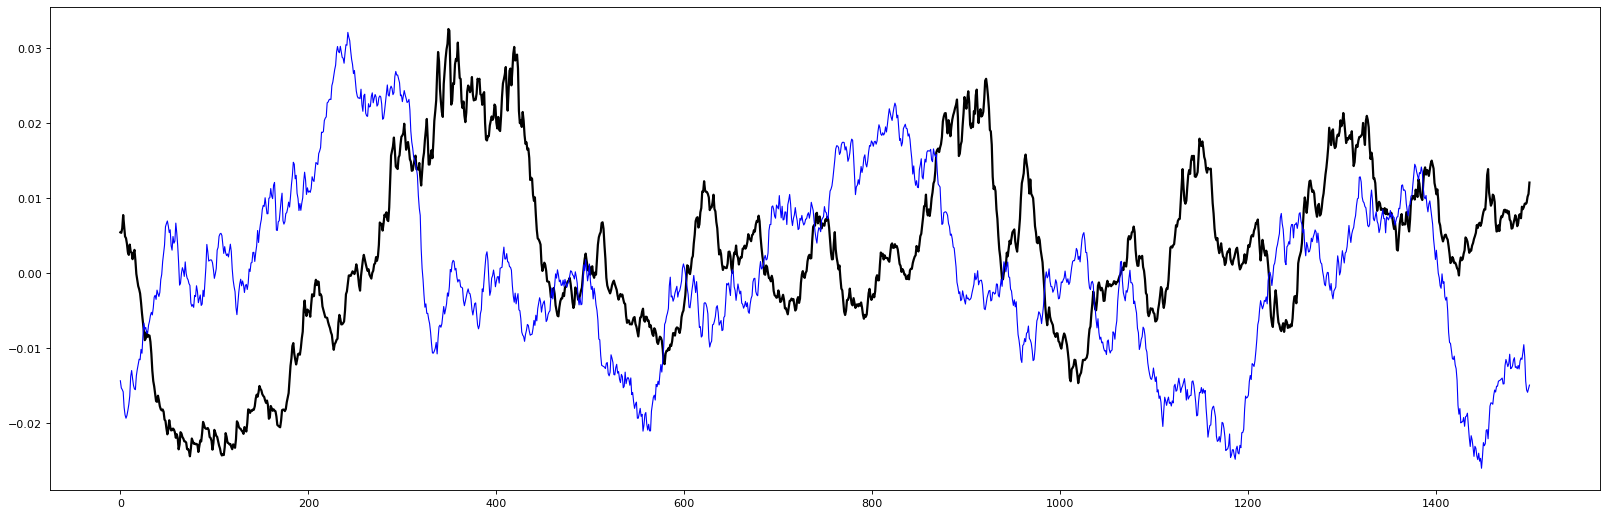

In [55]:
plt.figure(figsize=(25, 8), dpi=80)

t1 = 0
tf = 1500

plt.plot(orig_basin_ts[t1:tf], 'k', linewidth=2, label = 'Model Data')
plt.plot(rec_basin_ts[t1:tf],  'b', linewidth=1, label = 'Emulator Output')

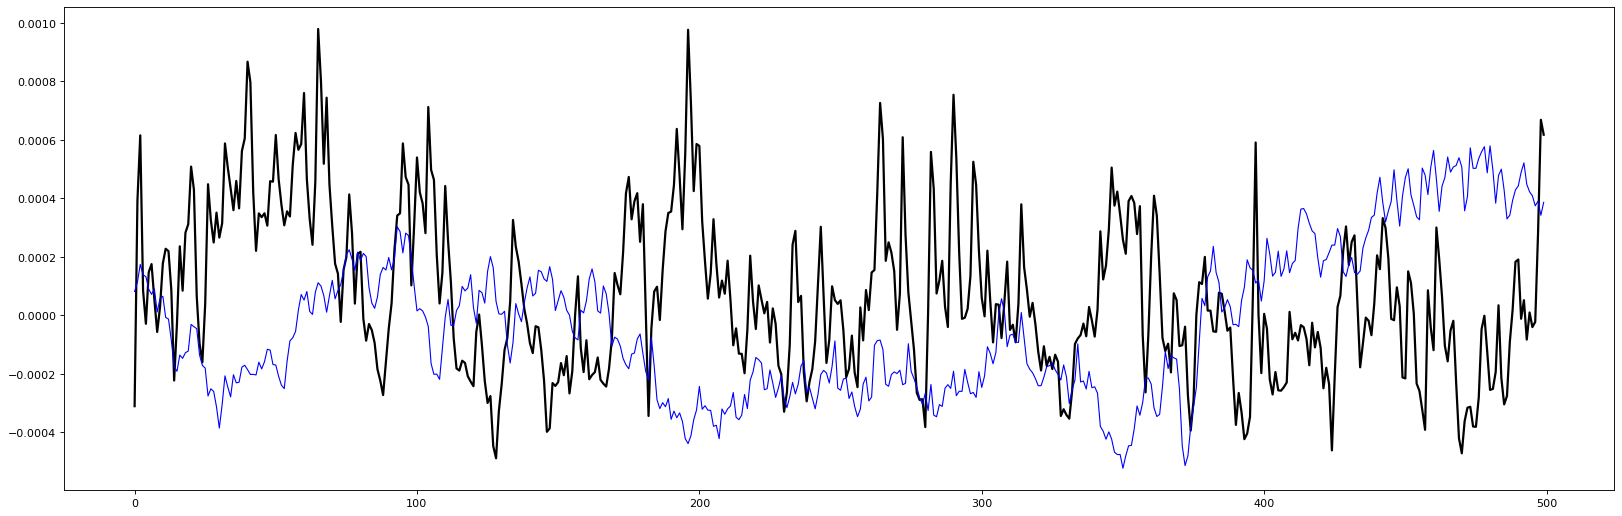

In [69]:
basin = 114
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);
orig_basin = flux_clean.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

rec_basin = flux_reconstr.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

# Remove NaN mask values to 'zoom' into catchment region
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")

orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

plt.figure(figsize=(25, 8), dpi=80)

t1 = 0
tf = 500

plt.plot(orig_basin_ts[t1:tf], 'k', linewidth=2, label = 'Model Data')
plt.plot(rec_basin_ts[t1:tf],  'b', linewidth=1, label = 'Emulator Output')


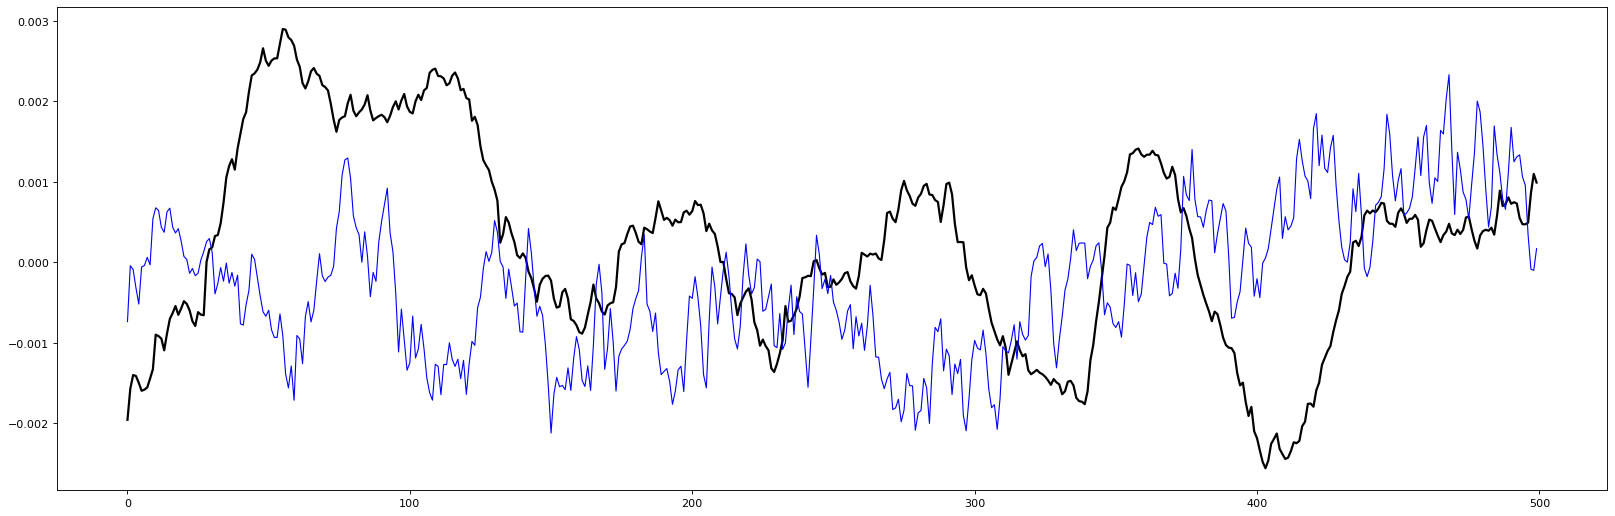

In [72]:
basin = 55
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);
orig_basin = flux_clean.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

rec_basin = flux_reconstr.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

# Remove NaN mask values to 'zoom' into catchment region
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")

orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

plt.figure(figsize=(25, 8), dpi=80)

t1 = 0
tf = 500

plt.plot(orig_basin_ts[t1:tf], 'k', linewidth=2, label = 'Model Data')
plt.plot(rec_basin_ts[t1:tf],  'b', linewidth=1, label = 'Emulator Output')


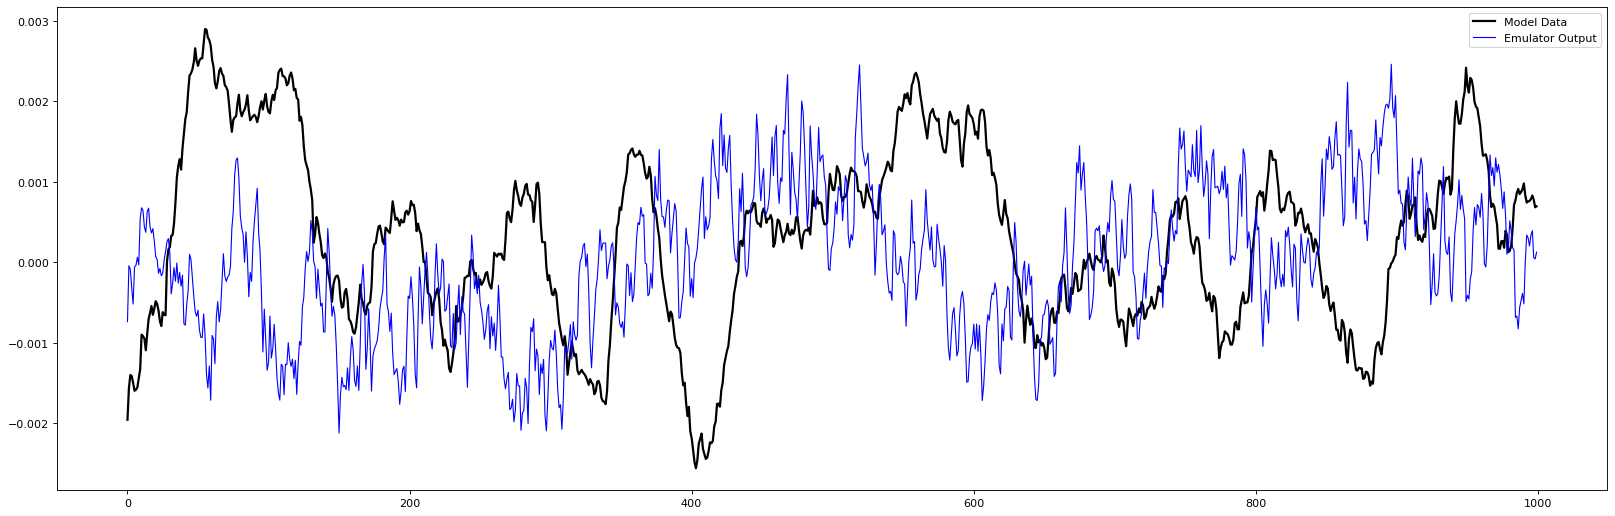

In [73]:
plt.figure(figsize=(25, 8), dpi=80)

t1 = 0
tf = 1000

plt.plot(orig_basin_ts[t1:tf], 'k', linewidth=2, label = 'Model Data')
plt.plot(rec_basin_ts[t1:tf],  'b', linewidth=1, label = 'Emulator Output')
plt.legend()

In [ ]:
# Vectorize data for statistical tests (F-test, Levene-test)
orig_basin_vec = orig_basin.stack(z=('x', 'y','time')).dropna('z',how='any').to_numpy()
rec_basin_vec = rec_basin.stack(z=('x', 'y','time')).dropna('z',how='any').to_numpy()

# Figures

In [ ]:
# ======================================================
# PHASE RANDOMIZED TIME SERIES PLOTS (PCs) =============
# ======================================================

plt.figure(figsize=(25, 8), dpi=80)

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,0],'b', linewidth=0.15)

plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[1,t1:tf,0],'b', linewidth=1)
plt.plot(new_fl[0,t1:tf,0],'b', linewidth=1)
plt.plot(fluxpcs[t1:tf,0],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.
          format((t1)/12,(tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(2,2,figsize=(20,8), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. 
# These should be modified to skip ocean flux values

colorbarmax = np.nanmax([orig_basin,rec_basin])
colorbarmin = np.nanmin([orig_basin,rec_basin])

plt.subplot(221)
cax1 = orig_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither','format':'%.5f','label':'Freshwater Flux'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Model Data", color= 'black', fontweight='bold')


plt.subplot(222)
cax2 = rec_basin[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = colorbarmax/2, vmin = colorbarmin/2,
                       cbar_kwargs={'extend':'neither','format':'%.5f','label':'Freshwater Flux'})
#plt.title("Phase Randomized Data: " + str(rec_basin.coords['time'].values[frame])[:7])
plt.title("Emulator Output", color= 'blue')

plt.subplot(2,2,(3,4))
cax3, = plt.plot(orig_basin_ts, 'k', linewidth=2, label = 'Model Data')
cax4, = plt.plot(rec_basin_ts,  'b', linewidth=1, label = 'Emulator Output')

"""
plt.plot(rec_basin1_ts,  'b', linewidth=0.25)
plt.plot(rec_basin2_ts,  'b', linewidth=0.25)
plt.plot(rec_basin3_ts,  'b', linewidth=0.25)
plt.plot(rec_basin4_ts,  'b', linewidth=0.25)
plt.plot(rec_basin5_ts,  'b', linewidth=0.25)
plt.plot(rec_basin6_ts,  'b', linewidth=0.25)
plt.plot(rec_basin7_ts,  'b', linewidth=0.25)
plt.plot(rec_basin8_ts,  'b', linewidth=0.25)
plt.plot(rec_basin9_ts,  'b', linewidth=0.25)
plt.plot(rec_basin10_ts,  'b', linewidth=0.25)


cax4, = plt.plot(rec_basin1_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin2_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin3_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin4_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin5_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin6_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin7_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin8_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin9_ts,  'b', linewidth=0.25)
cax4, = plt.plot(rec_basin10_ts,  'b', linewidth=0.25)
"""
plt.xlabel('Timestep')
plt.ylabel('Freshwater Flux')

plt.legend()

# Next we need to create a function that updates the values for 
# the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig_basin[frame,:,:].values.flatten())
    cax2.set_array(rec_basin[frame,:,:].values.flatten())
    cax3.set_ydata(orig_basin_ts[:frame]) # ANIMATED
    cax3.set_xdata(range(frame)) # ANIMATED
    cax3.set_marker('.')
    cax3.set_markersize(0.25)
    cax4.set_ydata(rec_basin_ts[:frame])
    cax4.set_xdata(range(frame))
    cax4.set_marker('.')
    cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_basin_ts[0:1499]),  # Could also be iterable or list
    interval=10     # ms between frames
)

In [ ]:
HTML(ani2.to_jshtml())

In [ ]:
#%matplotlib nbagg
import matplotlib
matplotlib.use('webagg')


In [ ]:
#HTML(ani2.to_jshtml())
ani2.save(inDirName+figures_folderpath+'AISLENS_Amery_Emulator_Comparison.mp4')

# Statistical Equivalence Tests

## Distribution of values in a grid cell over time and between realizations

In [ ]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [ ]:
f_test(orig_basin_vec, orig_basin_vec)

In [ ]:
lev_stat, lev_p = scipy.stats.levene(orig_basin_vec, rec_basin_vec)

In [ ]:
print(lev_stat, lev_p)

## Correlation between values in different grid cells

In [ ]:
eofsn = fluxeofs.dropna('time','all')

#scipy.stats.pearsonr(fluxeofs[0],fluxeofs[1])

## Time ACF of individual PCs and their randomized realizations

In [ ]:
rec_n = 24 # Select any realization (<= n_realizations)
mode_m = 500 # Select any mode (<= neofs)

fig, axs = plt.subplots(1,2,figsize=(20,8))

rec_acf = sm.graphics.tsa.plot_acf(new_fl[rec_n,:,mode_m],
                                   ax=axs[0],
                                   title='ACF (Randomized Realization, n = {} for mode={})'.
                                   format(rec_n,mode_m))
orig_acf = sm.graphics.tsa.plot_acf(fluxpcs[:,mode_m],
                                    ax=axs[1], 
                                    title='ACF (Original Data for mode={})'.
                                    format(mode_m))

## Time ACF of spatially correlated patterns of grid cells

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(20,8))

rec_acf = sm.graphics.tsa.plot_acf(orig_basin[:,70,35],
                                   ax=axs[0],
                                   title='ACF (Reconstructed Data) at (x,y)')
orig_acf = sm.graphics.tsa.plot_acf(rec_basin[:,70,35],
                                    ax=axs[1], 
                                    title='ACF (Original Data) at (x,y)')

In [ ]:
orig_basin[:,40,20]

## Power Spectral Density

In [ ]:
plt.figure(figsize=(35,8))
plt.psd(orig_basin_ts,label='Original', color='k')
plt.psd(rec_basin_ts,label='Randomized', color = 'b')
plt.title('PSD of original and reconstructed data: {}'.format(icems.name.values[basin]))
plt.legend()

fig, axs = plt.subplots(4,4,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,16):
    for i in range(0,15):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(fluxpcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {} : {}'.format(mode_m, icems.name.values[basin]))
plt.legend()

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,12))
axs=axs.ravel()
mode_start = 130

for mode_m in range(mode_start,mode_start+6):
    for i in range(0,15):
        axs[mode_m-mode_start].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m-mode_start].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m-mode_start].psd(fluxpcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m-mode_start].set_title('PSD of PC for mode {} : {}'.format(mode_m, icems.name.values[basin]))
plt.legend()

In [ ]:
infileTpath = "/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tas_annual_esm_rcp_r2i1p1_2006-2100.nc"

In [ ]:
T = xr.open_dataset("/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tas_annual_esm_rcp_r2i1p1_2006-2100.nc")

In [ ]:
P = xr.open_dataset("/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/pr_annual_esm_rcp_r2i1p1_2006-2100.nc")

In [ ]:
tann = xr.open_dataset("/Users/smurugan9/Library/R/arm64/4.1/library/fldgen/extdata/tann1.nc")

In [ ]:
tann.tas.shape